In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os, shutil
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import accuracy_score
import torchvision.models as models
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_transform = transforms.Compose([
     transforms.Resize([224,224]),
#     transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#     transforms.RandomRotation(degrees=15),#随机旋转15°
#     transforms.RandomHorizontalFlip(),#随机水平翻转图片
    #transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
all_dataset= torchvision.datasets.ImageFolder(root='dataset',transform=data_transform)

In [5]:
class_names = all_dataset.classes
print(class_names)

['hunzhuo', 'tuoli']


In [6]:
train_size = int(len(all_dataset) * 0.7)
test_size = len(all_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True,)

In [7]:
alexnet = models.alexnet(pretrained=False)
pthfile = r'alexnet-owt-4df8aa71.pth'
alexnet.load_state_dict(torch.load(pthfile))


In [8]:
# print(alexnet)
alexnet.classifier[-1].out_features=2
# print(alexnet)

In [9]:
model = alexnet

In [10]:
criterion=nn.CrossEntropyLoss()
params = filter(lambda p: p.requires_grad, model.parameters())
opti = torch.optim.Adam(params, lr=1e-5)

In [11]:
BARCH_SIZE=256
LR=0.0001
EPOCH=50

In [12]:
model = model.to(device)

In [13]:
if __name__ =='__main__':
    Accuracy_list = []
    Loss_list = []
 
    for epoch in range(EPOCH):
        sum_loss = 0.0
        correct1 = 0
 
        total1 = 0
        for i,(images,labels) in enumerate(train_loader):
            num_images=images.size(0)
 
            images=Variable(images.to(device))
            labels=Variable(labels.to(device))
 
            out=model(images)

            _, predicted = torch.max(out.data, 1)
 
            total1 += labels.size(0)
 
            correct1 += (predicted == labels).sum().item()
 
 
            loss=criterion(out,labels)
            print(loss)
            opti.zero_grad()
            loss.backward()
            opti.step()
 
            
            sum_loss += loss.item()
            if i % 2 == 0:
                print('[%d, %d] loss: %.03f'
                      % (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0 
        Accuracy_list.append(100.0*correct1 / total1)
        print('accurary={}'.format(100.0*correct1 / total1))
        Loss_list.append(loss.item())

tensor(11.1156, device='cuda:0', grad_fn=<NllLossBackward>)
[1, 1] loss: 0.111
tensor(10.7136, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.9004, device='cuda:0', grad_fn=<NllLossBackward>)
[1, 3] loss: 0.206
tensor(8.8744, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.0200, device='cuda:0', grad_fn=<NllLossBackward>)
[1, 5] loss: 0.169
tensor(7.3889, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6.6655, device='cuda:0', grad_fn=<NllLossBackward>)
[1, 7] loss: 0.141
accurary=0.0
tensor(6.3337, device='cuda:0', grad_fn=<NllLossBackward>)
[2, 1] loss: 0.063
tensor(5.6570, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(5.0610, device='cuda:0', grad_fn=<NllLossBackward>)
[2, 3] loss: 0.107
tensor(4.6480, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.8948, device='cuda:0', grad_fn=<NllLossBackward>)
[2, 5] loss: 0.085
tensor(3.4202, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4065, device='cuda:0', grad_fn=<NllLossBackward>)
[2, 7] loss: 0.058
accurar

In [14]:
class Model_w_GradCAM():
    def __init__(self, model: torch.nn.Module, category_index: int = None, aimed_module: str = None):
        # 给了model，就知道了默认要取的layer，输出类别数。
        self.model = model
        self.model_items = []
        self.get_model_reversed_layers(model)
        self.model_items.reverse()
        self.get_classes()
        self.chose_module(aimed_module)
        self.set_class_index(category_index)
        self.set_hook()
        pass

    def get_model_reversed_layers(self, perspective_model):
        for name, module in perspective_model._modules.items():
            if len(module._modules) > 0:
                self.get_model_reversed_layers(module)
            else:
                self.model_items.append([name, module])
    def set_hook(self):
        def forward_hook(module, input, output):
            self.feature_map = output.detach().cpu()  # bs,channels,size,size

        def backward_hook(module, grad_in, grad_out):
            self.grad_map = grad_out[0].detach().cpu()

        self.aimed_module.register_forward_hook(forward_hook)
        self.aimed_module.register_backward_hook(backward_hook)

    def get_classes(self):
        # 数有多少类
        last_layer = self.model_items[0][1]
        self.num_classes = last_layer.out_features

    def chose_module(self, aimed_module):
        # 选择要可视化的最后一个卷积层，有值就按名字选
        module = None
        for name, module in self.model_items:
            if not aimed_module:
                if isinstance(module, (torch.nn.modules.conv._ConvNd,)):
                    break
            else:
                if name == aimed_module:
                    break
        assert module != None
        self.aimed_module = module

    def set_class_index(self, category_index):
        # 设置固定类别
        if not category_index:
            self.category_index = None
        else:
            assert isinstance(category_index, int)
            assert category_index < self.num_classes
            self.category_index = category_index

    def draw_cam(self, imgs, preds, category_index=None) -> list:
        # imgs: RGB
        # preds: shape=1,c
        # batch预测需要指定类别
        # 求梯度
        if not isinstance(imgs, (list,)) or isinstance(imgs, (np.ndarray,)):
            imgs = [imgs]
        elif isinstance(imgs, (list,)):
            pass
        else:
            raise TypeError
        self.model.zero_grad()
        if category_index:
            self.set_class_index(category_index)  # 后指定/重设置
        assert len(imgs) == preds.shape[0]
        if not self.category_index:
            # 没有类别，就按最大值来
            preds = preds[:, torch.argmax(preds, 1)]
        else:
            preds = preds[:, self.category_index]
        # 必须独立求梯度,只能传一张
        class_loss = torch.sum(preds)
        class_loss.backward(retain_graph=True)
        # 可视化图
        self.grad_map = torch.mean(self.grad_map, [2, 3], keepdim=True)  # mb,c,1,1
        cam = self.grad_map * self.feature_map  # mb,c,mH,mW
        cam = torch.sum(cam, 1).numpy()  # mb,mH,mW

        heatmaps = []
        for i in range(len(cam)):
            hm = self.heatmap(imgs[i], cam[i])
            heatmaps.append(hm)
        return heatmaps

    def heatmap(self, img, cam):
        img = np.float32(img) / 255
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        # cam = np.maximum(cam, 0)# no elements is lower than zero.
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        # 附着
        heatmap = heatmap[..., ::-1] * 0.4 + np.float32(img)
        heatmap = heatmap / np.max(heatmap)
        heatmap = np.uint8(heatmap * 255)
        return heatmap

    def __call__(self, *args, **kwargs):
        preds = self.model(*args, **kwargs)  # softmax之前
        return preds
def img_preprocess(imgs):
    """
    读取图片，转为模型输入
    :param img_in: ndarray, [1,H, W, C]
    :return: PIL.image
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    ret_imgs = []
    if not isinstance(imgs, (list,)):
        imgs = [imgs]
    for img in imgs:
        img = img.copy()
        img = transform(img)
        ret_imgs.append(img)
    ret_imgs = torch.stack(ret_imgs, 0)
    return ret_imgs

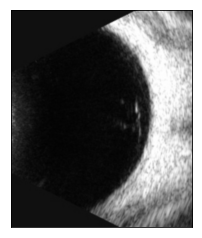

In [15]:
import cv2
classes = ('hunzhuo', 'tuoli')
img = cv2.imread('dataset/hunzhuo/hunzhuo0.jpg', 1)  # H*W*C
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
img = cv2.resize(img, (224, 224))
# plt.imsave( 'vgg16_ca_sa原图.png', img)
img = img[:, :, ::-1]  # BGR --> RGB
img_input = img_preprocess(img)
img_input=img_input.cuda()

In [16]:
net = Model_w_GradCAM(model)
output2 = net(img_input)

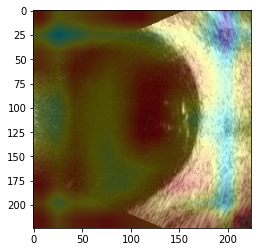

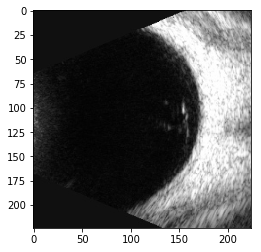

(<matplotlib.image.AxesImage at 0x7f20758a0dd8>, None)

In [17]:
cam = net.draw_cam([img], output2)[0]
from matplotlib import pyplot as plt
plt.imshow(cam), plt.show()
plt.imsave( 'alexnet.png', cam)
plt.imshow(img), plt.show()

In [14]:
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import type_of_target

from sklearn.metrics import precision_score, recall_score, f1_score
def computeTestSetAccuracy(model, loss_function):
#     device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
    test_acc = 0.0
    test_loss = 0.0
    precision =0.0
    recall = 0.0
    f1score = 0.0
    predlabel_list =[]
    pred_list = []
    with torch.no_grad():
        model.eval()
 
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            a = labels.tolist()
            
            for x in a:
#                 print(type(x))
                predlabel_list.append(x)
            
            outputs = model(inputs)
 
            loss = loss_function(outputs, labels)
 
            test_loss += loss.item() * inputs.size(0)
 
            ret, predictions = torch.max(outputs.data, 1)
    
            b = predictions.tolist()
            for z in b:
                pred_list.append(z)
                
            correct_counts = predictions.eq(labels.data.view_as(predictions))
 
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
            test_acc += acc.item() * inputs.size(0)
 
            print("Test Batch Number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(
                j, loss.item(), acc.item()
            ))
            for j in range(inputs.size()[0]):
                print("model {} pred label:{}, true label:{}".format(len(predictions), class_names[predictions[j]], class_names[labels[j]]))
                if predictions[j] != labels[j]:
                    img = inputs[j].cpu().numpy()
                    img = img*0.5+0.5
                    img = img*255
                    img = img.transpose([1,2,0])
                    img =img.astype(np.uint8)
                    plt.imshow(img)
                    plt.show()
#     print(predlabel_list)      
    test_data_size = len(test_dataset)
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size
    p = precision_score(predlabel_list, pred_list)  
    r = recall_score(predlabel_list, pred_list)  
    f1 = f1_score(predlabel_list, pred_list) 
    print('precision:'+str(p))
    print('recall:'+str(r))
    print('f1-score:'+str(f1)) 
    print("Test accuracy : " + str(avg_test_acc))
#     class_report = classification_report(predlabel_list,pred_list,target_names=['class 0','class 1'])
#     print(class_report)


Test Batch Number: 000, Test: Loss: 0.0878, Accuracy: 1.0000
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
Test Batch Number: 001, Test: Loss: 0.3928, Accuracy: 0.9000
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuol

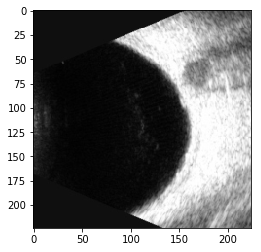

Test Batch Number: 002, Test: Loss: 0.2429, Accuracy: 0.8000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:tuoli


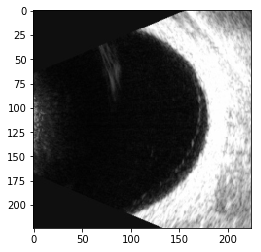

model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


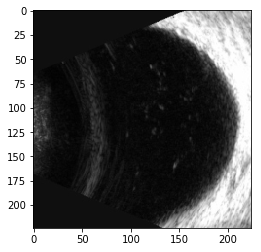

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
Test Batch Number: 003, Test: Loss: 0.1020, Accuracy: 1.0000
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
Test Batch Number: 004, Test: Loss: 0.2491, Accuracy: 0.9000
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
mo

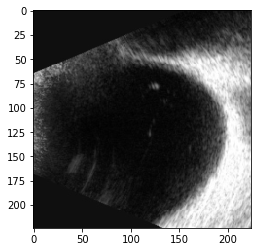

model 10 pred label:hunzhuo, true label:hunzhuo
Test Batch Number: 005, Test: Loss: 0.6378, Accuracy: 0.8000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:hunzhuo


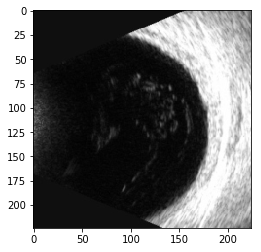

model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:hunzhuo


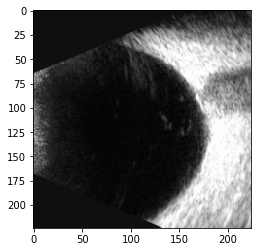

model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 006, Test: Loss: 0.2861, Accuracy: 0.9000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


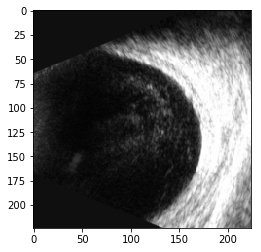

model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 007, Test: Loss: 0.6467, Accuracy: 0.7000
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


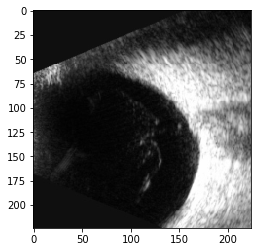

model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


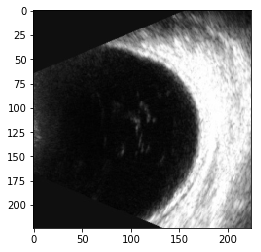

model 10 pred label:tuoli, true label:hunzhuo


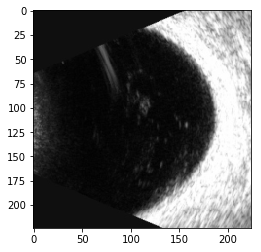

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 008, Test: Loss: 0.7449, Accuracy: 0.8000
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


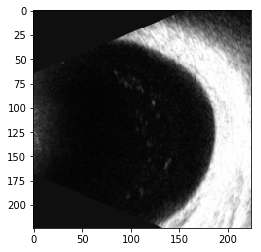

model 10 pred label:hunzhuo, true label:tuoli


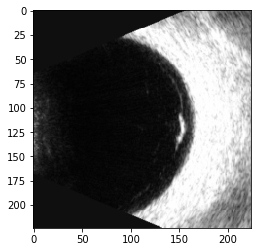

model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 009, Test: Loss: 0.0491, Accuracy: 1.0000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 010, Test: Loss: 0.3642, Accuracy: 0.7000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:hunzhuo


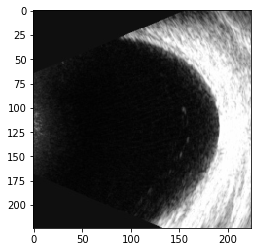

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


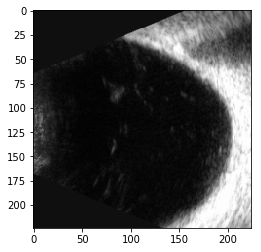

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:tuoli


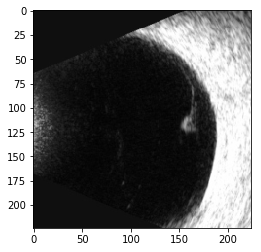

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 011, Test: Loss: 1.4138, Accuracy: 0.7000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:hunzhuo


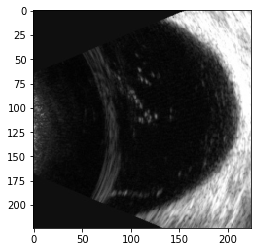

model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:hunzhuo


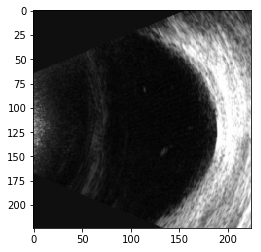

model 10 pred label:tuoli, true label:hunzhuo


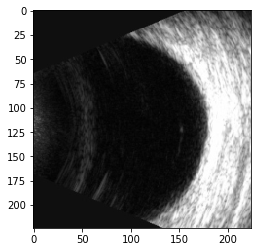

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
Test Batch Number: 012, Test: Loss: 0.1618, Accuracy: 0.9000
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:tuoli


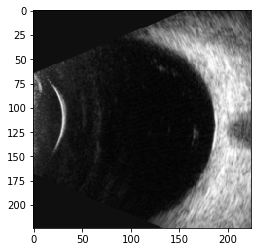

model 10 pred label:tuoli, true label:tuoli
model 10 pred label:tuoli, true label:tuoli
model 10 pred label:hunzhuo, true label:hunzhuo
model 10 pred label:hunzhuo, true label:hunzhuo
Test Batch Number: 013, Test: Loss: 2.3259, Accuracy: 0.3333
model 3 pred label:tuoli, true label:tuoli
model 3 pred label:tuoli, true label:hunzhuo


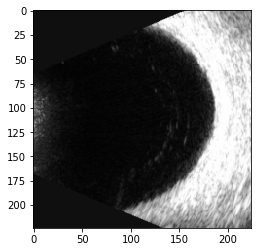

model 3 pred label:tuoli, true label:hunzhuo


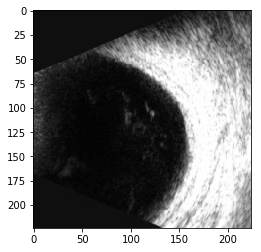

precision:0.777777777778
recall:0.918032786885
f1-score:0.842105263158
Test accuracy : 0.8421052562114888


In [15]:
computeTestSetAccuracy(model,criterion)

第一次
precision:0.794520547945
recall:0.840579710145
f1-score:0.816901408451
Test accuracy : 0.80451128088442

第二次
precision:0.823529411765
recall:0.875
f1-score:0.848484848485
Test accuracy : 0.8496240579095998

第三次
precision:0.881355932203
recall:0.8125
f1-score:0.845528455285
Test accuracy : 0.8571428499723736

第四次
precision:0.881355932203
recall:0.8125
f1-score:0.845528455285
Test accuracy : 0.8571428477315974


第五次
precision:0.777777777778
recall:0.918032786885
f1-score:0.842105263158
Test accuracy : 0.8421052562114888